##Data Preparation/implementaiton of dlib


Start by importing necessary libraries and installing dlib for facial landmark identification.

In [ ]:
import pandas as pd
!apt-get install build-essential cmake
!apt-get install libopenblas-dev liblapack-dev 
!pip3 install dlib
import dlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
liblapack-dev is already the newest version (3.7.1-4ubuntu1).
libopenblas-dev is already the newest version (0.2.20+ds-4).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

Now mount the drive folder containing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


For dlib, we now create the predictor that will identify landmarks.

In [ ]:
landmark_detector = dlib.shape_predictor('drive/MyDrive/ML_Final/shape_predictor_68_face_landmarks.dat')

Reviewing what the labels look like. We can see that they are all the same but some are capitalized.

In [ ]:
labels_beforepreprocess = pd.read_csv('drive/MyDrive/ML_Final/facial_expressions-master/data/legend.csv')['emotion'].value_counts()


Because the files are out of order we are creating a dictionary of filenames and lowercase labels.

In [ ]:
import csv
label_dict = {}
with open('drive/MyDrive/ML_Final/facial_expressions-master/data/legend.csv','r') as legend:
  csv_r = csv.reader(legend)
  for line in csv_r:
    label_dict[line[1]] = line[2].lower()

In [ ]:
import numpy as np
np.unique(np.array(list(label_dict.values())),return_counts=True)

(array(['anger', 'contempt', 'disgust', 'emotion', 'fear', 'happiness',
        'neutral', 'sadness', 'surprise'], dtype='<U9'),
 array([ 252,    9,  208,    1,   21, 5693, 6864,  268,  367]))

Let's now load in the full dataset. We want to try to get a class balance so aim for 300 of each of our labels. Let's load all the data in as well as identify which individuals are for which images. This will be important in the future when we want to split our data and ensure that individuals' images are still grouped together.

In [ ]:
import os
import numpy as np
import tqdm
from skimage.transform import resize

directory = r'drive/MyDrive/ML_Final/facial_expressions-master/images/'
images = []
labels = []
c = 0
name_indices = {}
desired_counts = {x:300 for x in ['neutral','happiness','surprise','anger',
                                  'sadness']}
desired_counts['fear'] = 0
desired_counts['contempt'] = 0
desired_counts['disgust'] = 0
sad_encountered = 0
anger_encountered = 0
for filename in tqdm.tqdm(os.listdir(directory)):
  if filename in label_dict and desired_counts[label_dict[filename]] > 0:
    try: 
      curr_image = dlib.load_grayscale_image('drive/MyDrive/ML_Final/facial_expressions-master/images/' + filename)
      if ((curr_image.shape[1] == 350) and (curr_image.shape[0] == 350)):
        name = ''.join([i for i in filename if not i.isdigit()])
        if name in name_indices:
          name_indices[name].append(c)
        else:
          name_indices[name] = [c]

        images.append(curr_image)
        labels.append(label_dict[filename])

        desired_counts[label_dict[filename]] -= 1

        if ((label_dict[filename] == 'sadness') & (sad_encountered % 2 == 0)):
          
          images.append(skimage.img_as_ubyte(resize(rotate(curr_image, 20, resize = True), (350, 350))))
          labels.append(label_dict[filename])
          c = c + 1
          name_indices[name].append(c)
          sad_encountered = sad_encountered + 1
          desired_counts[label_dict[filename]] -= 1
          images.append(skimage.img_as_ubyte(resize(skimage.util.random_noise(curr_image), (350, 350))))
          
          labels.append(label_dict[filename])
          
          c = c + 1
          name_indices[name].append(c)
          sad_encountered = sad_encountered + 1
          desired_counts[label_dict[filename]] -= 1
        elif ((label_dict[filename] == 'sadness') & (sad_encountered % 2 == 1)):
          images.append(skimage.img_as_ubyte(resize(rotate(curr_image, 20, resize = True), (350, 350))))
          labels.append(label_dict[filename])
          c = c + 1
          name_indices[name].append(c)
          sad_encountered = sad_encountered + 1
          desired_counts[label_dict[filename]] -= 1
        elif ((label_dict[filename] == 'anger') & (anger_encountered % 2 == 1)):
          images.append(skimage.img_as_ubyte(resize(rotate(curr_image, 20, resize = True), (350, 350))))
          labels.append(label_dict[filename])
          c = c + 1
          name_indices[name].append(c)
          anger_encountered = anger_encountered + 1
          desired_counts[label_dict[filename]] -= 1
        if ((label_dict[filename] == 'anger') & (anger_encountered % 2 == 0)):
          
          images.append(skimage.img_as_ubyte(resize(rotate(curr_image, 20, resize = True), (350, 350))))
          labels.append(label_dict[filename])
          c = c + 1
          name_indices[name].append(c)
          anger_encountered = anger_encountered + 1
          desired_counts[label_dict[filename]] -= 1
          images.append(skimage.img_as_ubyte(resize(skimage.util.random_noise(curr_image), (350, 350))))
          labels.append(label_dict[filename])
          
          c = c + 1
          name_indices[name].append(c)
          anger_encountered = anger_encountered + 1
          desired_counts[label_dict[filename]] -= 1

        c = c + 1


    except: 
      continue  
  
  


100%|██████████| 13718/13718 [10:09<00:00, 22.52it/s]


One popular name is George W Bush. Let's look at all of the images of him as well as the dlib predictions for the facial landmarks.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


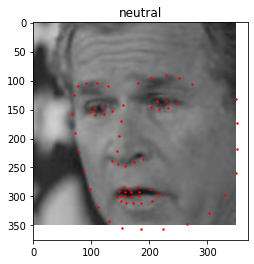

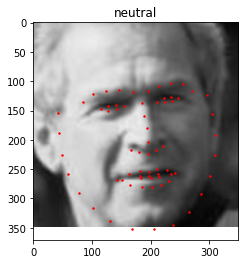

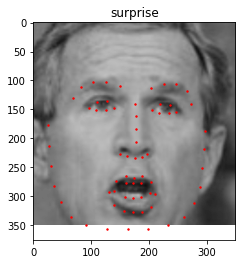

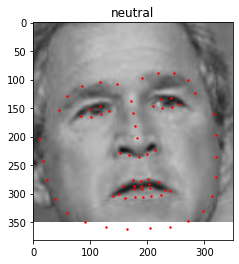

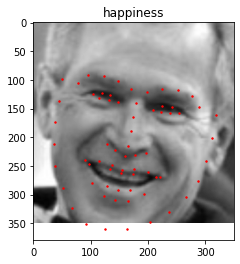

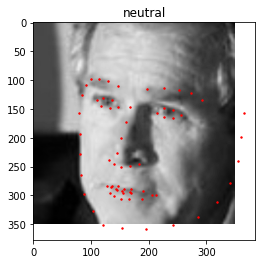

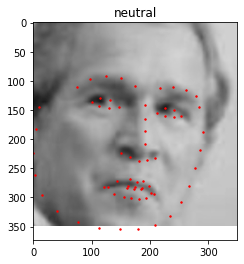

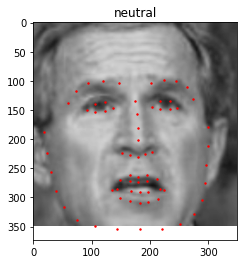

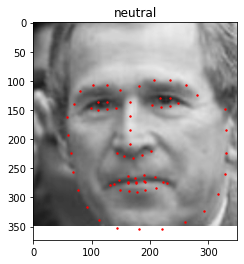

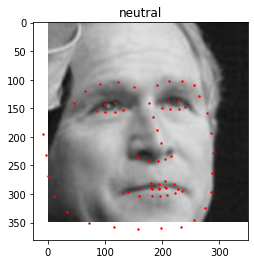

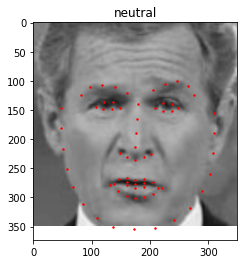

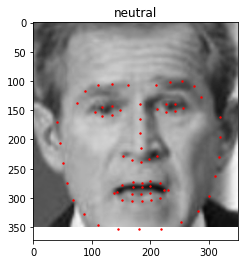

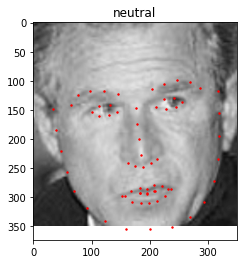

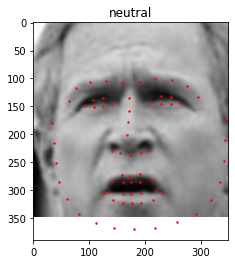

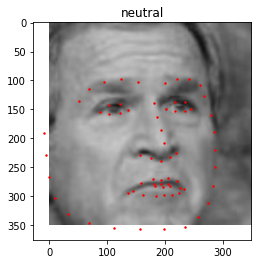

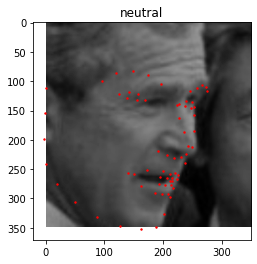

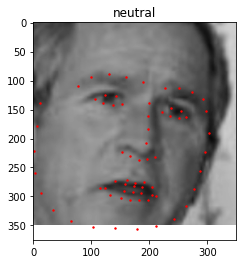

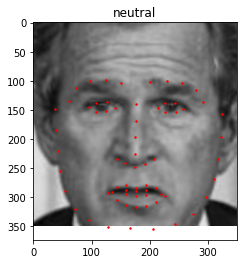

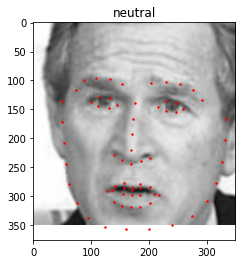

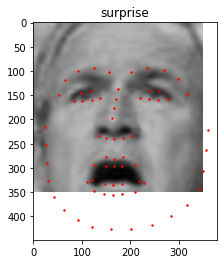

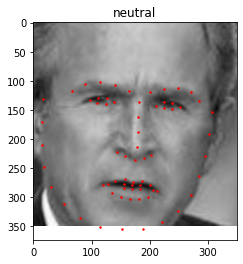

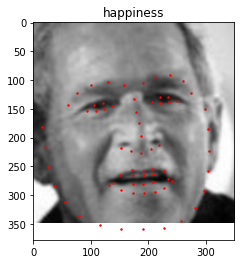

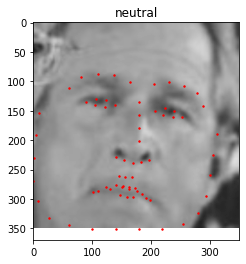

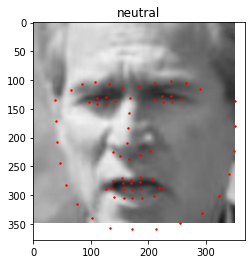

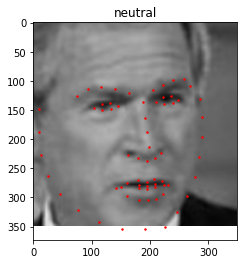

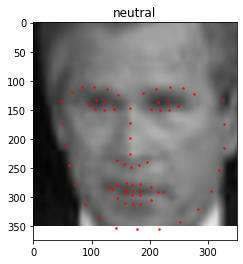

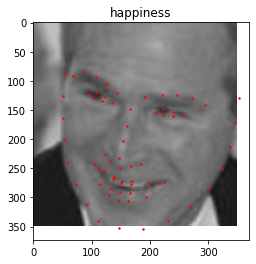

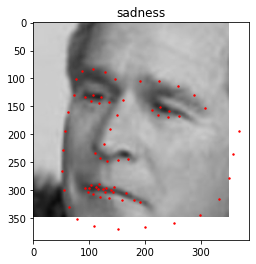

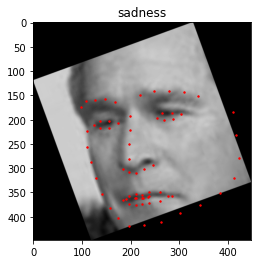

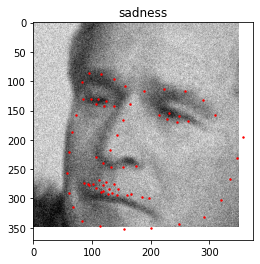

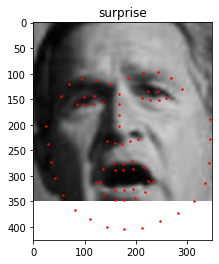

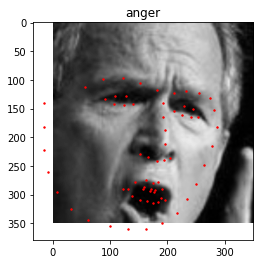

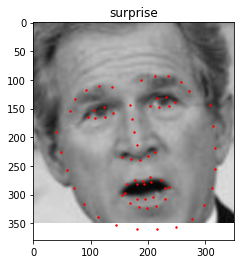

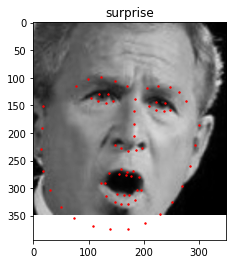

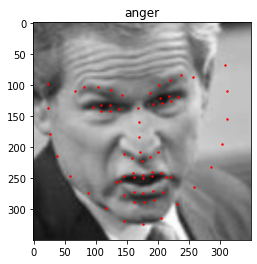

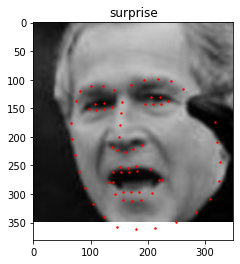

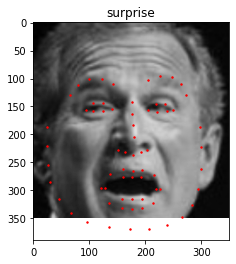

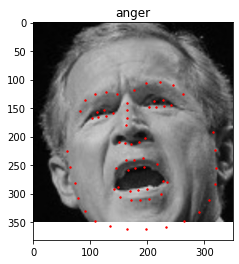

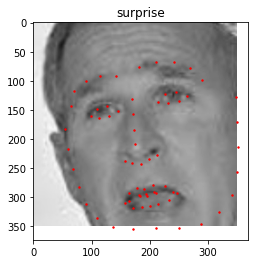

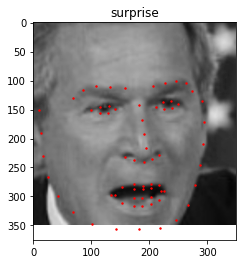

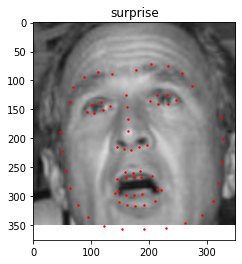

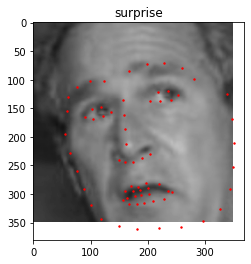

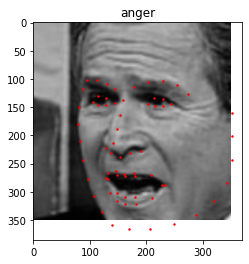

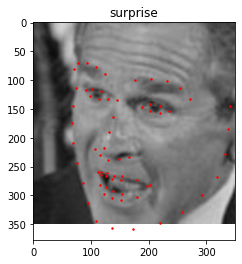

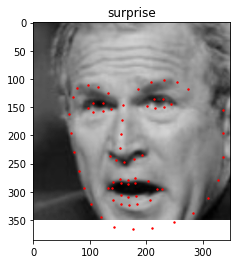

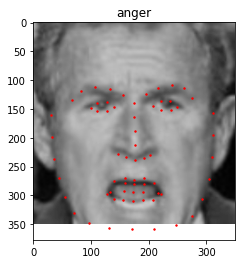

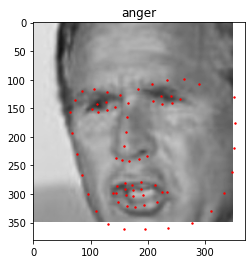

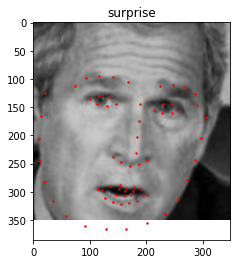

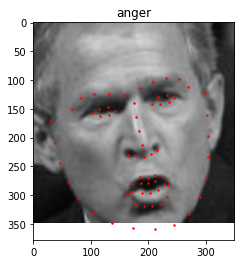

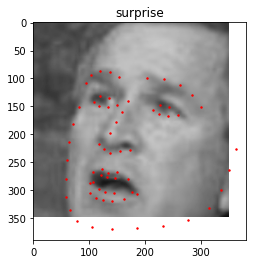

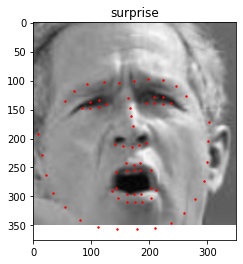

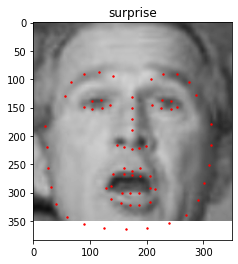

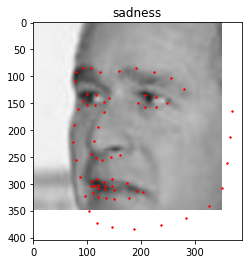

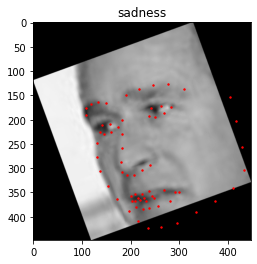

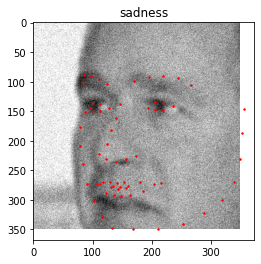

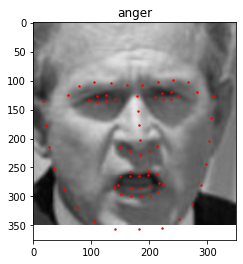

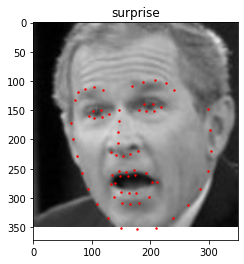

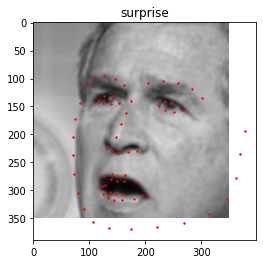

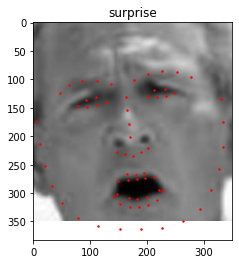

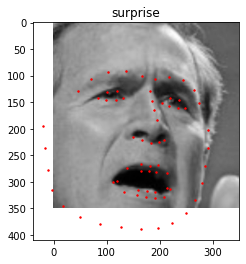

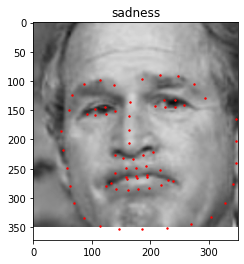

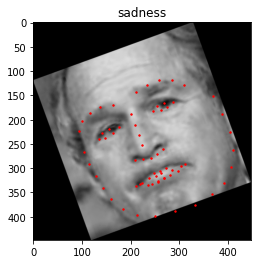

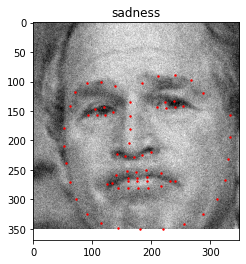

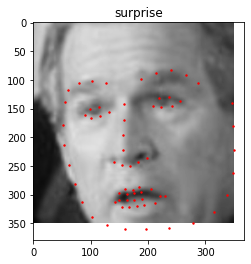

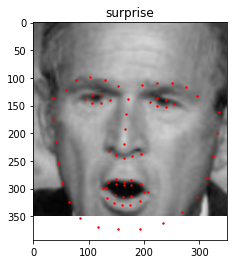

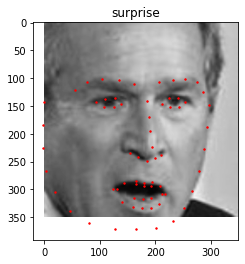

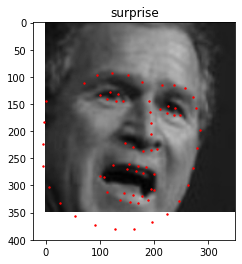

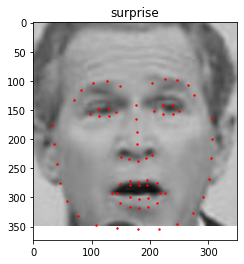

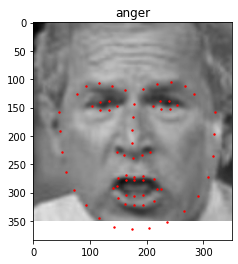

In [ ]:
for i in name_indices['George_W_Bush_.jpg']:
  img = images[i]
  rect = dlib.rectangle(0,0,img.shape[1],img.shape[0])
  #print(img)
  landmarks = landmark_detector(img,rect)
  plt.figure()
  plt.title(labels[i])
  plt.imshow(img,cmap='gray', vmin=0, vmax=255)
  for p in landmarks.parts():
    plt.scatter(p.x,p.y,s=2,c='r')

Apart from some issues with side profiles, dlib performs very well here.

To quantify the dlib predictions, we'll store all our data in a numpy array where each row is an image containing 136 columns (an x and y coordinate for each of the 68 landmarks). This results in a flattened representation of the data.

In [ ]:
images = np.array(images)
landmarks = []

for img in images:
  rect = dlib.rectangle(0,0,img.shape[1],img.shape[0])
  try:
    landmark_curr = landmark_detector(img,rect)
    landmarks.append([[i.x,i.y] for i in landmark_curr.parts()])
  except:
    continue

landmarks = np.array(landmarks)

In [ ]:
landmarks_flat = np.reshape(landmarks, (1500, 136))
landmarks_flat.shape

(1500, 136)

In [ ]:
landmarks_flat

array([[ 67, 158,  71, ..., 301, 158, 299],
       [ 54, 131,  56, ..., 284, 158, 281],
       [ 85, 146,  78, ..., 281, 132, 277],
       ...,
       [ 20, 128,  22, ..., 297, 175, 297],
       [ -4, 158,  -3, ..., 275, 158, 272],
       [ -8, 151,  -4, ..., 315, 174, 316]])

To split our data, we want to make sure that all people with the same name are in the same split. Thus, we split based on the names first and then insert the appropriate data.

In [ ]:
names = list(name_indices.keys())
names = pd.DataFrame(names)
names.head

<bound method NDFrame.head of                            0
0         George_W_Bush_.jpg
1    Rubens_Barrichello_.jpg
2          Pete_Sampras_.jpg
3            Andy_North_.jpg
4         Colin_Farrell_.jpg
..                       ...
770     Beyonce_Knowles_.jpg
771      Tatiana_Panova_.jpg
772         Hubie_Brown_.jpg
773        Luis_Sanchez_.jpg
774       Shanna_Zolman_.jpg

[775 rows x 1 columns]>

In [ ]:
train, validate, test = np.split(names.sample(frac=1, random_state=42), 
                       [int(.6*len(names)), int(.8*len(names))])

In [ ]:
train = train.values.tolist()
train = [item for sublist in train for item in sublist]
train_ivals = []
for name in train:
  i_curr = name_indices[name]
  train_ivals.append(i_curr)

train_ivals = [item for sublist in train_ivals for item in sublist]
train_images = landmarks_flat[train_ivals]

In [ ]:
validate = validate.values.tolist()
validate = [item for sublist in validate for item in sublist]
validate_ivals = []
for name in validate:
  i_curr = name_indices[name]
  validate_ivals.append(i_curr)

validate_ivals = [item for sublist in validate_ivals for item in sublist]
validate_images = landmarks_flat[validate_ivals]

In [ ]:
test = test.values.tolist()
test = [item for sublist in test for item in sublist]
test_ivals = []
for name in test:
  i_curr = name_indices[name]
  test_ivals.append(i_curr)

test_ivals = [item for sublist in test_ivals for item in sublist]
test_images = landmarks_flat[test_ivals]

In [ ]:
y_train = [labels[i] for i in train_ivals]
y_validate = [labels[i] for i in validate_ivals]
y_test = [labels[i] for i in test_ivals]

In [ ]:
len(y_train) + len(y_validate) + len(y_test)

1500

In [ ]:
np.save('X_train', train_images)
np.save('y_train', y_train)
np.save('X_validate', validate_images)
np.save('y_validate', y_validate)
np.save('X_test', test_images)
np.save('y_test', y_test)

In [ ]:
np.save('X_train_upsample', train_images)
np.save('y_train_upsample', y_train)
np.save('X_validate_upsample', validate_images)
np.save('y_validate_upsample', y_validate)
np.save('X_test_upsample', test_images)
np.save('y_test_upsample', y_test)

In [ ]:
images.shape

(1500, 350, 350)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(labels)
y = le.transform(labels)

In [ ]:
np.savez("./image_dataset_upsample.npz", x=images,y=y)

In [ ]:
data = np.load("image_dataset_upsample.npz")

In [ ]:
!ls *.npz

image_dataset_upsample.npz


In [ ]:
!pwd

/content


In [ ]:
images

array([[[188, 188, 186, ...,  45,  44,  44],
        [188, 188, 186, ...,  44,  43,  43],
        [188, 188, 186, ...,  41,  40,  40],
        ...,
        [123, 123, 122, ...,  98,  98,  98],
        [122, 122, 121, ...,  99,  99, 100],
        [122, 122, 121, ...,  99, 100, 100]],

       [[135, 135, 135, ..., 107, 106, 106],
        [135, 135, 135, ..., 106, 106, 106],
        [136, 136, 136, ..., 106, 106, 106],
        ...,
        [184, 184, 182, ..., 197, 191, 191],
        [184, 183, 181, ..., 194, 186, 187],
        [184, 183, 181, ..., 193, 185, 186]],

       [[ 50,  50,  50, ...,  34,  35,  35],
        [ 50,  50,  50, ...,  34,  35,  35],
        [ 50,  50,  50, ...,  33,  34,  34],
        ...,
        [198, 198, 198, ...,  63,  56,  55],
        [199, 199, 199, ...,  66,  56,  55],
        [199, 199, 199, ...,  67,  55,  54]],

       ...,

       [[ 30,  29,  29, ...,  72,  71,  71],
        [ 30,  30,  29, ...,  72,  71,  71],
        [ 32,  31,  31, ...,  72,  71,  71

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
len(images)

1427

In [ ]:
images[10].shape

(350, 350)

In [ ]:
count = 0
for i in range(len(images)):
  curr = images[i]
  if (curr.shape == (350, 350)):
    count = count + 1

print(count)

images_new = np.zeros((count, 350, 350))
for i in range(len(images)):
  curr = images[i]
  if (curr.shape == "(350, 350)"):
    images_new[i] = curr


1327


In [ ]:
images_new.shape

(1327, 350, 350)